In [1]:
%matplotlib inline

In [3]:
# License: BSD

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.functional as F
import matplotlib.image as mpimg
plt.ion()   # interactive mode

In [4]:
def rotate90(x):
    from scipy.ndimage.interpolation import rotate
    rotated = rotate(x, 90.0, reshape=False,axes=(0, 1))
    return rotated

In [5]:
def flip(x):
    flipped = np.flip(np.flip(x.copy(), axis=0), axis=1)
    return flipped

In [6]:
def add_noise(x):
    added = x.copy()
    added[:, :, :] += np.random.randint(0, 5, [x.shape[0],x.shape[1],x.shape[2]],dtype='uint8') *5
    return added

In [12]:
def aug(img, rnd):
    if rnd ==1:
        aug_img = rotate90(img)
    elif rnd ==2:
        aug_img = flip(img)
    else:
        aug_img = add_noise(img)
    return aug_img

In [13]:
def rgb2gray(rgb):
    grey = np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
    grey = np.expand_dims(grey, axis =2)
    return grey

In [14]:
root= 'uploads/train'
imgs_dirs = [os.path.join(root,cat) for cat in os.listdir(root) if not cat.startswith('.')]
imgs = []
for imgs_dir in imgs_dirs:
    imgs_single = [os.path.join(imgs_dir,img) for img in os.listdir(imgs_dir) if not img.startswith('.')]
    imgs_single = sorted(imgs_single, key=lambda x: int(x.split('.')[-2].split('/')[-1]))
    imgs.append(imgs_single)
imgs = sum(imgs,[])
imgs = sorted(imgs, key=lambda x: int(x.split('.')[-2].split('/')[-1]))

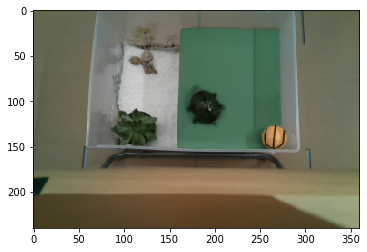

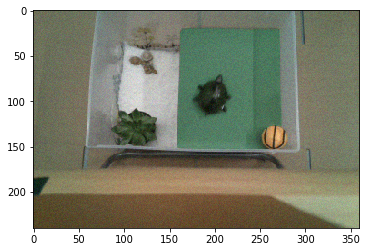

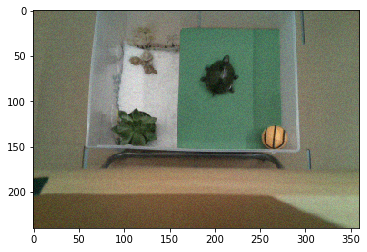

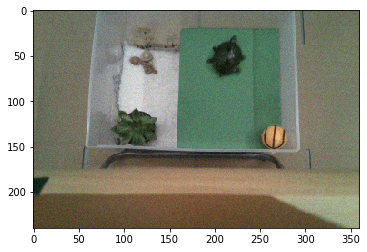

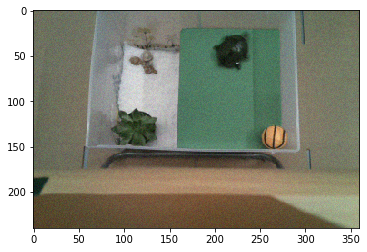

In [18]:
idx=10
idx_real = idx * 5
img_path = imgs[idx_real]
image = mpimg.imread(img_path)
plt.imshow(image)
plt.show()
is_transform = np.random.randint(0,2)
if(is_transform == 1):
    rnd = np.random.randint(1,4)
#     rnd = 3
    samples = aug(image, rnd)
    samples = rgb2gray(samples)
    for i in range(1,5):
        img_path = imgs[idx_real+i]
        image = mpimg.imread(img_path)
        sample = aug(image,rnd)
        plt.imshow(sample)
        plt.show()
        sample = rgb2gray(sample)
        samples = np.concatenate((samples, sample),axis=2)
        
    samples = samples.transpose((2, 0, 1))
else:
    samples = image
    samples = rgb2gray(samples)
    for i in range(1,5): 
        img_path = imgs[idx_real+i]
        sample = mpimg.imread(img_path)
        plt.imshow(sample)
        plt.show()
        sample = rgb2gray(sample)
        samples = np.concatenate((samples, sample),axis=2)
        
    samples = samples.transpose((2, 0, 1))

Load Data
---------

In [73]:
class CustomDataset(Dataset):
    def __init__(self, root, concat=5, transform=None):
        categories = [cat for cat in os.listdir(root) if not cat.startswith('.')]
        imgs_dirs = [os.path.join(root,cat) for cat in os.listdir(root) if not cat.startswith('.')]
        imgs = []
        for imgs_dir in imgs_dirs:
            imgs_single = [os.path.join(imgs_dir,img) for img in os.listdir(imgs_dir) if not img.startswith('.')]
            imgs_single = sorted(imgs_single, key=lambda x: int(x.split('.')[-2].split('/')[-1]))
            imgs.append(imgs_single)
        imgs = sum(imgs,[])
        imgs_num = int(len(imgs)/concat)
        self.imgs_num = imgs_num
        self.categories = categories
        self.imgs = imgs
        self.transform = transform
        self.concat = concat
    def __getitem__(self, idx):
        idx_real = idx * self.concat
        category = str(self.imgs[idx_real].split('/')[-2].split('/')[-1])
        label = self.categories.index(category)
        img_path = self.imgs[idx_real]
        image = mpimg.imread(img_path)
        is_transform = np.random.randint(0,2)
        if(is_transform == 1):
            rnd = np.random.randint(1,4)
            samples = self.transform(image, rnd)
            for i in range(1,self.concat):
                img_path = self.imgs[idx_real+i]
                image = mpimg.imread(img_path)
                sample = self.transform(image,rnd)
                samples = np.concatenate((samples, sample),axis=2)
            samples = samples.transpose((2, 0, 1))
        else:
            samples = image
            for i in range(1,self.concat): 
                img_path = self.imgs[idx_real+i]
                sample = mpimg.imread(img_path)
                samples = np.concatenate((samples, sample),axis=2)
            samples = samples.transpose((2, 0, 1))
        return (samples, label)
    def __len__(self):
        return self.imgs_num

In [78]:
# load data
PATH = "./uploads/train"
dataset_train = CustomDataset(PATH,transform=aug)
batch_size = 14
validation_split = 0.20
shuffle_dataset = True
random_seed= 5

# Creating data indices for training and validation splits:
dataset_size = len(dataset_train)
print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
# Creating subset samplers and corresponding loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, 
                                           sampler=valid_sampler)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataloaders={'train':train_loader, 'val':validation_loader}
dataset_sizes={'train':len(train_sampler), 'val':len(valid_sampler)}

700
560
[273, 587, 357, 510, 518, 596, 72, 306, 564, 349, 461, 143, 441, 317, 346, 117, 662, 396, 37, 501, 326, 66, 261, 368, 120, 432, 23, 585, 481, 526, 636, 322, 134, 151, 632, 467, 440, 71, 293, 197, 336, 365, 104, 558, 199, 84, 222, 642, 634, 695, 230, 686, 123, 622, 176, 166, 478, 448, 108, 638, 232, 503, 429, 3, 131, 242, 423, 52, 341, 363, 697, 643, 698, 121, 148, 247, 248, 45, 516, 42, 451, 28, 514, 512, 555, 35, 89, 420, 676, 406, 7, 244, 361, 40, 568, 330, 601, 604, 228, 33, 224, 193, 405, 464, 279, 327, 354, 99, 203, 267, 236, 212, 141, 360, 545, 302, 608, 445, 486, 21, 527, 355, 178, 373, 450, 132, 208, 283, 460, 356, 342, 533, 419, 312, 325, 149, 677, 666, 615, 567]


Training the model
------------------

A general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model


In [78]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            y_score = []
            y = []
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                print(inputs)
                inputs = inputs.to(device,dtype=torch.float)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
#                 print(preds)
#                 print(labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model,'models/densenet121_another')
    return model

In [ ]:
model_ft = models.AlexNet(pretrained=True)

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.

In [79]:
#densenet121
model_ft = models.densenet121(pretrained=True)
model_ft.features.conv0 =  nn.Conv2d(15, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 7)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0005)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [80]:
model_ft

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(15, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [49]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8001 Acc: 0.7857
val Loss: 0.6493 Acc: 0.8286
Epoch 1/24
----------
train Loss: 0.4338 Acc: 0.9540
val Loss: 0.4023 Acc: 0.9714
Epoch 2/24
----------
train Loss: 0.4546 Acc: 0.9476
val Loss: 0.4071 Acc: 0.9429
Epoch 3/24
----------
train Loss: 0.4294 Acc: 0.9556
val Loss: 0.3661 Acc: 0.9857
Epoch 4/24
----------
train Loss: 0.4320 Acc: 0.9540
val Loss: 0.4192 Acc: 0.9857
Epoch 5/24
----------
train Loss: 0.4376 Acc: 0.9476
val Loss: 0.4069 Acc: 0.9571
Epoch 6/24
----------
train Loss: 0.4355 Acc: 0.9492
val Loss: 0.4256 Acc: 0.9429
Epoch 7/24
----------
train Loss: 0.4214 Acc: 0.9524
val Loss: 0.4363 Acc: 0.9429
Epoch 8/24
----------
train Loss: 0.4550 Acc: 0.9460
val Loss: 0.4232 Acc: 0.9286
Epoch 9/24
----------
train Loss: 0.4326 Acc: 0.9540
val Loss: 0.3847 Acc: 0.9714
Epoch 10/24
----------
train Loss: 0.4245 Acc: 0.9651
val Loss: 0.4202 Acc: 0.9143
Epoch 11/24
----------
train Loss: 0.4261 Acc: 0.9540
val Loss: 0.4143 Acc: 0.9714
Epoch 12/24
--

## Test

The task is mainly to record the result into .csv file. I finally got 0.9000 in accuracy. But my validation accuracy is about 0.99. So, maybe something wrong with my validation set.

In [50]:
MODEL_PATH = "models/"
model_ft = torch.load(MODEL_PATH + 'densenet121')
model_ft.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(15, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [100]:
def test(img_path):
    res_list = ['tree', 'stop', 'turn', 'over', 'play', 'go', 'stone']
    data = mpimg.imread(img_path)
    idx = int(img_path.split('.')[-2].split('/')[-1])
    for i in range(1,5):
        t = idx - i
        img_path = 'uploads/test/%s.jpg' % t
        sample = mpimg.imread(img_path)
        data = np.concatenate((data, sample),axis=2)
    data = data.transpose((2, 0, 1))
    data = np.expand_dims(data, axis=0)
    data = torch.from_numpy(data)
    MODEL_PATH = "models/"
    model_ft = torch.load(MODEL_PATH + 'densenet121')
    model_ft.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        data = data.to(device,dtype=torch.float)
        outputs = model_ft(data)
        _, pred = torch.max(outputs.data, 1)
    result = res_list[pred.cpu()]
    return result

In [101]:
img_path = 'uploads/test/104.jpg'
result = test(img_path)

over


In [17]:
labels=(results.data).cpu().numpy()
ds = pd.Series({id : label for (id, label) in zip(ids, labels)})
ds.head()
df = pd.DataFrame(ds, columns = ['label']).sort_index()
df['id'] = df.index
df = df[['id', 'label']]
df.head(5)

df.to_csv( PATH+'submission.csv', index = False)

In [63]:
import pickle
import numpy as np
def clear():
    d_res = {'history':{'tree': 0, 'stop': 0, 'turn': 0, 'over': 0, 'play': 0, 'go': 0, 'stone': 0}}
    d_pers = {'personality':'Mysterious'}
    d_mood = {'mood':{'flat': 0, 'excited': 0, 'tired': 0, 'worry': 0, 'think good': 0, 'think bad': 0}}
    d_current_pred = {'current': -1}
    d_mood_link = {'mood_link':{'tree': {'think bad':1}, 'stop': {'tired':1}, 'turn': {'excited':1}, 'over': {'worry':1}, 'play': {'excited':5}, 'go': {'flat':1}, 'stone': {'think good':1}}}
    predictions = dict(d_current_pred, **d_res)
    predictions = dict(predictions, **d_pers)
    predictions = dict(predictions, **d_mood)
    predictions = dict(predictions, **d_mood_link)

    print(predictions)
    f = open('predictions.pkl', 'wb')
    pickle.dump(predictions,f)
    f.close()

In [54]:
pred = 'over'
new_pred = {'current': pred}
predictions.update(new_pred)
predictions['history'][pred] = predictions['history'][pred]+1
print(predictions)

{'current': 'over', 'history': {'tree': 0, 'stop': 0, 'turn': 0, 'over': 1, 'play': 0, 'go': 0, 'stone': 0}, 'personality': 'Mysterious', 'mood': {'flat': 0, 'excited': 0, 'tired': 0, 'worry': 0, 'think good': 0, 'think bad': 0}, 'mood_link': {'tree': {'think bad': 1}, 'stop': {'tired': 1}, 'turn': {'excited': 1}, 'over': {'worry': 1}, 'play': {'excited': 5}, 'go': {'flat': 1}, 'stone': {'think good': 1}}}


In [61]:
def judge(pred):
    #settings
    max_count_mood = 10
    discount_factor = 0.5
    f = open('predictions.pkl', 'rb')
    predictions = pickle.load(f)
    f.close()
    res_pred = {'current': pred}
    predictions.update(new_pred)
    predictions['history'][pred] = predictions['history'][pred] + 1
    mood_pair = predictions['mood_link'][pred]
    for key, value in mood_pair.items():
        predictions['mood'][key] = predictions['mood'][key] + value
    
    res_mood = list(predictions['mood'].keys())[np.argmax([value for value in predictions['mood'].values()])]
    if (np.max([value for value in predictions['mood'].values()]) > max_count_mood):
        new_dict = {'flat': 0, 'excited': 0, 'tired': 0, 'worry': 0, 'think good': 0, 'think bad': 0}
        predictions['mood'].update(new_dict)
        predictions['mood'][res_mood] = int(max_count_mood * discount_factor)
    res_pers = predictions['personality']
    if ((predictions['history']['go'] + predictions['history']['play'] + predictions['history']['turn'] + predictions['history']['over']) 
        - (predictions['history']['stop'] + predictions['history']['stone'] + predictions['history']['tree'])) > 200:
        res_pers = 'Outgoing'
        predictions['personality'] = res_pers
    if (predictions['history']['over'] > 30) or (((predictions['history']['turn'] + predictions['history']['play'])
     - (predictions['history']['go'] + predictions['history']['stop'] + predictions['history']['stone'] + predictions['history']['tree'])) > 50):
        res_pers = 'Childish'
        predictions['personality'] = res_pers
    if (((predictions['history']['stop'] + predictions['history']['stone'] + predictions['history']['tree']) 
        - (predictions['history']['go'] + predictions['history']['play'] + predictions['history']['turn'] + predictions['history']['over']) 
        )> 200) and (predictions['history']['stop'] - predictions['history']['stone'] - predictions['history']['tree'] > 100):
        res_pers = 'Lazy'
        predictions['personality'] = res_pers
    if ((predictions['history']['stone'] + predictions['history']['tree']) 
        - (predictions['history']['go'] + predictions['history']['stop'] + predictions['history']['turn'] + predictions['history']['over'] + predictions['history']['play'])) > 200:
        res_pers = 'Thoughtful'
        predictions['personality'] = res_pers
        
    f = open('predictions.pkl', 'wb')
    pickle.dump(predictions,f)
    f.close()

In [62]:
judge('over')

In [ ]:
# outgoing: (go+play+turn+over) - (stop+stone+tree) > 200
# childish: over > 30 or (turn+play)-(go+stop+stone+tree)> 50 
# lazy: (stop+stone+tree) - (go+turn+over+play) > 200 and stop-(stone+tree) > 100
# thoughtful: (stone+tree)-(go+stop+turn+over+play) > 200

In [1]:
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn
import math

In [42]:
def get_new_fig(fn, figsize=[10,10]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    #Get Current Axis
    ax1 = fig1.gca()  
    # clear existing plot
    ax1.cla()        
    return fig1, ax1

In [43]:
def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0, if_total=False):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = sum(array_df[lin])
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(if_total and (col == ((ccl - 1)) or (lin == (ccl - 1)))):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('black')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('black')

    return text_add, text_del

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[10,10], show_null_values=0, pred_val_axis='y', if_total=False):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
        show_null_values= 0: does not show 0 at all
                          1: show number but not percentage
                          2: show both number of percentage
        if_total          True: have total column, False:does not have total column
    """
    # change label here
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted status'
        ylbl = 'True status'
    else:
        xlbl = 'True status'
        ylbl = 'Predicted status'
        df_cm = df_cm.T

    # create "Total" column
    if(if_total):
        insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    # change color bar title
    cbar_kws = {'label': 'number of misclassification'}
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt, cbar_kws=cbar_kws)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = True
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = True
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    # add/remove title here
    # ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()


#
#TEST functions
#
def _test_cm():
    #test function with confusion matrix done
    array = np.array([[15,  0,  0,  0,  0,  0,  3],
        [ 0, 19,  0,  0,  0,  1,  0],
        [ 0,  0, 19,  0,  0,  0,  0],
        [ 0,  0,  0, 25,  0,  0,  0],
        [ 0,  0,  0,  0, 20,  0,  0],
        [ 0,  0,  0,  0,  0, 19,  0],
        [ 3,  0,  0,  0,  0,  0, 16]])

    #get pandas dataframe
    df_cm = DataFrame(array, index=range(0,7), columns=range(0,7))
    #colormap: see this and choose your more dear
    cmap = 'PuRd'
    pretty_plot_confusion_matrix(df_cm, cmap=cmap, show_null_values=2, pred_val_axis="x", cbar=False, fz=10)

/home/ecbm4040/miniconda3/envs/envTF113/lib/python3.6/site-packages/ipykernel_launcher.py:127: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/home/ecbm4040/miniconda3/envs/envTF113/lib/python3.6/site-packages/ipykernel_launcher.py:128: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/home/ecbm4040/miniconda3/envs/envTF113/lib/python3.6/site-packages/ipykernel_launcher.py:130: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/home/ecbm4040/miniconda3/envs/envTF113/lib/python3.6/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.


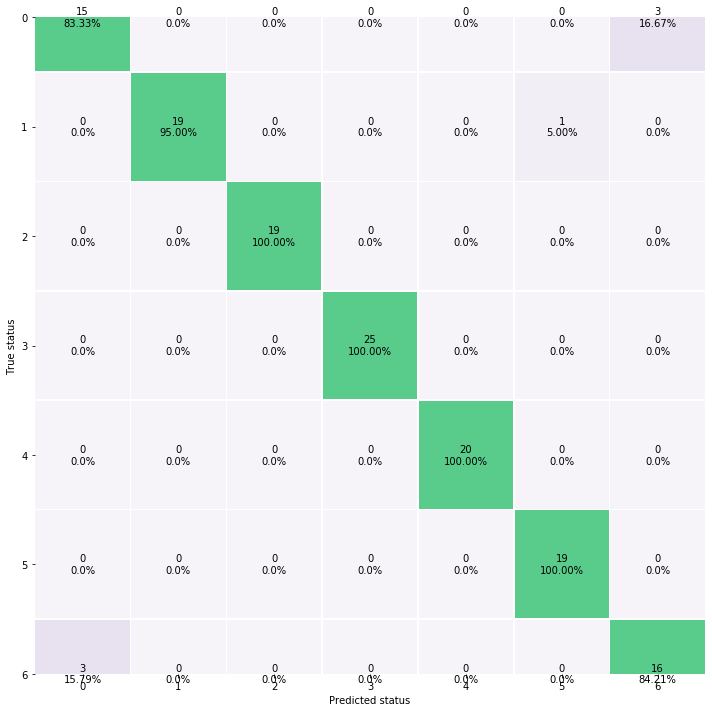

In [44]:
_test_cm()